# TTC Delay Data

In this notebook, the exploratory data analysis will be conducted to the current TTC delay data from January 1, 2014 to September 30, 2023. The issues will be explored are:
1. Data composition
2. Time related trend
3. Top delay factors
4. Mechanical issues
5. Top delay at each station
6. Weather related delays

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from datetime import datetime as dt

%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings("ignore")

1. import data

In [2]:
# Find all ttc subway ridership data file from the path
filenames = [file for file in os.listdir("TTC_delay") if ('ttc-subway-delay' in file) and (not 'readme' in file) and (not 'codes' in file)]
filenames

['ttc-subway-delay-data-2018.xlsx',
 'ttc-subway-delay-data-2019.xlsx',
 'ttc-subway-delay-data-2020.xlsx',
 'ttc-subway-delay-data-2021.xlsx',
 'ttc-subway-delay-data-2022.xlsx',
 'ttc-subway-delay-data-2023.xlsx',
 'ttc-subway-delay-jan-2014-april-2017.xlsx',
 'ttc-subway-delay-may-december-2017.xlsx']

In [3]:
def combine_excel_sheets(filenames, folder_path):
    all_dataframes = []

    # Read through all sheets of Excel file and combine as a dataframe
    for file in filenames:
        try:
            # Read the Excel file
            xls = pd.ExcelFile(os.path.join(folder_path, file))
            # Get all sheets names
            sheet_names = xls.sheet_names

            # Combine all dataframes
            combined_df = pd.concat([xls.parse(sheet_name) for sheet_name in sheet_names], ignore_index = True)

            # Append the combined dataframe to the list
            all_dataframes.append(combined_df)

        # If there are any errors to read the file
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    # Make all_dataframes as a dataframe
    result_df = pd.concat(all_dataframes, ignore_index = True)
    
    return result_df



In [4]:
# Import TTC delay codes
delayed_data = combine_excel_sheets(filenames, r"TTC_delay")
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781


In [5]:
print(delayed_data.shape)

(188121, 10)


In [6]:
print(delayed_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188121 entries, 0 to 188120
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       188121 non-null  datetime64[ns]
 1   Time       188121 non-null  object        
 2   Day        188121 non-null  object        
 3   Station    188121 non-null  object        
 4   Code       188120 non-null  object        
 5   Min Delay  188121 non-null  int64         
 6   Min Gap    188121 non-null  int64         
 7   Bound      142443 non-null  object        
 8   Line       187478 non-null  object        
 9   Vehicle    188121 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 14.4+ MB
None


import delay codes

In [7]:
# Import TTC delay codes
codes = pd.read_excel(os.path.join('TTC_delay', 'ttc-subway-delay-codes.xlsx'), header = 1)
codes.head()

,Unnamed: 0,Unnamed: 1,SUB RMENU CODE,CODE DESCRIPTION,Unnamed: 4,Unnamed: 5,SRT RMENU CODE,CODE DESCRIPTION.1
0,NaN,1,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
1,NaN,2,EUAL,Alternating Current,NaN,2.0,ERBO,Body
2,NaN,3,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
3,NaN,4,EUBK,Brakes,NaN,4.0,ERCO,Couplers
4,NaN,5,EUBO,Body,NaN,5.0,ERDB,Disc Brakes


In [8]:
# Since the code abbreviation and code describtion are divided into four different columns, seperate them into two dataframe and concat into one
TTC_delay_code_name_raw_1 = pd.DataFrame({
    "Code": codes.iloc[:,2],
    "Code description": codes.iloc[:,3]
})
TTC_delay_code_name_raw_2 = pd.DataFrame({
    "Code": codes.iloc[:,6],
    "Code description": codes.iloc[:,7]
})

TTC_delay_code_name = pd.concat([TTC_delay_code_name_raw_1, TTC_delay_code_name_raw_2], axis=0)

## Reset the index
TTC_delay_code_name = TTC_delay_code_name.reset_index(drop=True)

## Take a look
TTC_delay_code_name.head()

,Code,Code description
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [9]:
## Add the column "code duscription" into TTC 2023 delay data 
delayed_data = pd.merge(delayed_data, TTC_delay_code_name, on="Code", how='left')
delayed_data.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
0,2018-01-01,00:29,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
1,2018-01-01,01:07,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2,2018-01-01,01:22,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
3,2018-01-01,01:28,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
4,2018-01-01,01:39,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [10]:
# Combine date and time data and convert it to datetime type
delayed_data["Datetime"] = pd.to_datetime(delayed_data['Date'].astype(str) + ' ' + delayed_data['Time'])
## Drop the "Time" and "Date" columns
delayed_data = delayed_data.drop(columns='Time')
delayed_data = delayed_data.drop(columns='Date')

delayed_data

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,Datetime
0,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,2018-01-01 00:29:00
1,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,2018-01-01 01:07:00
2,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,2018-01-01 01:22:00
3,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,2018-01-01 01:28:00
4,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,2018-01-01 01:39:00
...,...,...,...,...,...,...,...,...,...,...
188173,Sunday,KEELE STATION,SUUT,0,0,W,BD,5245,Unauthorized at Track Level,2017-12-31 23:24:00
188174,Sunday,BAY STATION,PUMEL,0,0,NaN,BD,0,Escalator/Elevator Incident,2017-12-31 23:44:00
188175,Sunday,WARDEN STATION,MUSC,0,0,W,BD,5225,Miscellaneous Speed Control,2017-12-31 23:44:00
188176,Sunday,GLENCAIRN STATION,SUUT,10,14,S,YU,5576,Unauthorized at Track Level,2017-12-31 23:58:00


In [11]:
# Set the Datetime as the index
delayed_data = delayed_data.set_index("Datetime")
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description
Datetime,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other


In [12]:
# Create a function to capture the what time interval does each datetime index falls

def get_hour_interval(hour):
    start_hour = f"{hour:02d}:00"
    end_hour = f"{(hour + 1) % 24:02d}:00"  # Use modulo 24 for the hour after 23:00 to wrap around to 00:00
    return f"{start_hour} - {end_hour}"

In [13]:
# Create a new column for time interval
delayed_data['time_interval'] = delayed_data.index.hour.map(get_hour_interval)
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YU,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YU,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YU,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YU,5781,Miscellaneous Other,01:00 - 02:00


In [14]:
# Check subway lines
delayed_data["Line"].unique()

array(['YU', 'BD', 'SRT', 'SHP', 'YU/BD', nan, 'YU / BD', 'YU/ BD',
       'YU-BD', 'BLOOR DANFORTH LINES', '999', 'BD/YU', '16 MCCOWAN',
       'YUS', 'YONGE UNIVERSITY SERVI', '704 RAD BUS', 'B/D', 'BD LINE',
       'YU & BD', 'YU\\BD', '46 MARTIN GROVE', 'RT', 'BLOOR-DANFORTH',
       '134 PROGRESS', 'YU - BD', '985 SHEPPARD EAST EXPR', '22 COXWELL',
       '100 FLEMINGDON PARK', 'YU LINE', '29 DUFFERIN', '95 YORK MILLS',
       '35 JANE', 'BLOOR - DANFORTH', 'YU/BD LINE', 'YUS/BD',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       'YUS/DB', 'SHEP', 'YONGE/UNIVERSITY/BLOOR', '36 FINCH WEST',
       'YUS & BD', 'YU & BD LINES', '52', '41 KEELE', 'Y/BD',
       'YU/BD LINES', 'YUS AND BD', '69 WARDEN SOUTH', 'LINE 2 SHUTTLE',
       '57 MIDLAND', '96 WILSON', '506 CARLTON', 'BLOOR DANFORTH & YONGE',
       'BD LINE 2', 'BD/YUS', 'BLOOR DANFORTH', '31 GREENWOOD', '60',
       '9 BELLAMY', '45 KIPLING', '504', '500', 'SHEPPARD', '104 FAYWOOD',
       '60 STEELE

In [15]:
# Replace subway line to the standard
delayed_data["Line"] = delayed_data["Line"].replace(['YU / BD', 'YU/ BD', 'YU-BD', 'BD/YU', 
                                                     'YU & BD', 'YU\\BD', 'YU/BD LINE', 
                                                     'YUS/BD', 'YUS/DB', 'YUS & BD', 
                                                     'YU & BD LINES', 'Y/BD', 'YU/BD LINES',
                                                     'YUS AND BD', 'BLOOR DANFORTH & YONGE',
                                                     'BD/YUS', 'YU BD', 'YU - BD LINE', 
                                                     'YU - BD', 'YONGE/UNIVERSITY/BLOOR'] ,"YU/BD")
delayed_data["Line"] = delayed_data["Line"].replace(['BLOOR DANFORTH LINES', 'B/D', 'BD LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"BD")
delayed_data["Line"] = delayed_data["Line"].replace(['YU', 'YONGE UNIVERSITY SERVI', 'YU LINE', 
                                                     'BLOOR-DANFORTH', 'BLOOR - DANFORTH', 
                                                     'BD LINE 2', 'BLOOR DANFORTH', 'BLOOR DANFORTH LINE',
                                                     ] ,"YUS")
delayed_data["Line"] = delayed_data["Line"].replace(['SHEPPARD', 'SHEP'] ,'SHP')

delayed_data["Line"].unique()


array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', nan, '999', '16 MCCOWAN',
       '704 RAD BUS', '46 MARTIN GROVE', 'RT', '134 PROGRESS',
       '985 SHEPPARD EAST EXPR', '22 COXWELL', '100 FLEMINGDON PARK',
       '29 DUFFERIN', '95 YORK MILLS', '35 JANE',
       '40 JUNCTION-DUNDAS WES', '71 RUNNYMEDE', '102 MARKHAM ROAD',
       '36 FINCH WEST', '52', '41 KEELE', '69 WARDEN SOUTH',
       'LINE 2 SHUTTLE', '57 MIDLAND', '96 WILSON', '506 CARLTON',
       '31 GREENWOOD', '60', '9 BELLAMY', '45 KIPLING', '504', '500',
       '104 FAYWOOD', '60 STEELES WEST', '25 DON MILLS', '555',
       '126 CHRISTIE', '37 ISLINGTON', '504 KING', '116 MORNINGSIDE',
       '73 ROYAL YORK', 'YU/SHEP', '66', '341 KEELE', '510 SPADINA',
       '11 BAYVIEW', '63 OSSINGTON', '32 EGLINTON WEST',
       '129 MCCOWAN NORTH', '85 SHEPPARD EAST'], dtype=object)

In [16]:
# Filter subway lines out
delayed_data = delayed_data[delayed_data["Line"].isin(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'YU/SHEP'])]
delayed_data.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00


In [17]:
# Double check
subway_lines = delayed_data["Line"].unique()
subway_lines

array(['YUS', 'BD', 'SRT', 'SHP', 'YU/BD', 'YU/SHEP'], dtype=object)

In [18]:
# See the size of the delayed_data now
delayed_data.shape

(187474, 10)

In [19]:
# Save the cleaned data to a .csv file
delayed_data.to_csv("TTC_Subway_Delay_Data_2014_to_2023_Cleaned.csv")

2. Explore the time data

In [20]:
# Filter out the delays more than 1 minute
real_delay = delayed_data.loc[(delayed_data["Min Delay"] != 0) & (delayed_data["Min Gap"] != 0)]
real_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 00:29:00,Monday,SHEPPARD WEST STATION,MUATC,10,15,N,YUS,5986,ATC Project,00:00 - 01:00
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 02:09:00,Monday,KIPLING STATION,MUSAN,3,7,E,BD,5261,Unsanitary Vehicle,02:00 - 03:00
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00


In [21]:
# See how many real delays are there
real_delay.shape

(63542, 10)

In [22]:
# Check real delay infos
real_delay.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63542 entries, 2018-01-01 00:29:00 to 2017-12-31 23:58:00
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Day               63542 non-null  object
 1   Station           63542 non-null  object
 2   Code              63542 non-null  object
 3   Min Delay         63542 non-null  int64 
 4   Min Gap           63542 non-null  int64 
 5   Bound             62915 non-null  object
 6   Line              63542 non-null  object
 7   Vehicle           63542 non-null  int64 
 8   Code description  63279 non-null  object
 9   time_interval     63542 non-null  object
dtypes: int64(3), object(7)
memory usage: 5.3+ MB


In [23]:
# See the empty Code description codes --> No description for those
real_delay[real_delay["Code description"].isnull()]

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-11 00:23:00,Thursday,CASTLE FRANK STATION,PUTDN,4,8,E,BD,5112,NaN,00:00 - 01:00
2018-01-15 06:03:00,Monday,ISLINGTON STATION,PUTDN,3,7,E,BD,5313,NaN,06:00 - 07:00
2018-02-17 18:46:00,Saturday,MAIN STREET STATION,PUTDN,10,14,W,BD,5206,NaN,18:00 - 19:00
2018-04-04 18:11:00,Wednesday,WILSON STATION,PUTDN,8,11,S,YUS,6026,NaN,18:00 - 19:00
2018-05-04 17:29:00,Friday,ROSEDALE STATION,PUTDN,11,13,N,YUS,5906,NaN,17:00 - 18:00
...,...,...,...,...,...,...,...,...,...,...
2017-09-02 22:56:00,Saturday,FINCH STATION,PUTDN,12,16,N,YUS,5656,NaN,22:00 - 23:00
2017-10-15 18:05:00,Sunday,EGLINTON STATION,PUTDN,8,12,S,YUS,5101,NaN,18:00 - 19:00
2017-11-21 10:21:00,Tuesday,WARDEN STATION,PUTDN,3,6,W,BD,5082,NaN,10:00 - 11:00


didn't find MUNCA meaning from the code file.

In [24]:
# Calculate the real delay percentage
real_delay_per = real_delay.shape[0] / delayed_data.shape[0]
print("There are {}% of delay events caused delay more than 1 minutes.".format(round(real_delay_per*100, 2)))

There are 33.89% of delay events caused delay more than 1 minutes.


In [25]:
real_delay.to_csv("TTC_Real_Delay_2014_to_2023.csv")

In [26]:
# Create the dataframe without delay
no_delay = delayed_data.loc[(delayed_data["Min Delay"] == 0) & (delayed_data["Min Gap"] == 0)]
no_delay.head()

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 01:07:00,Monday,DUNDAS STATION,MUNCA,0,0,NaN,YUS,0,NaN,01:00 - 02:00
2018-01-01 01:22:00,Monday,MUSEUM STATION,MUSC,0,0,N,YUS,5751,Miscellaneous Speed Control,01:00 - 02:00
2018-01-01 01:28:00,Monday,BAY LOWER,EUOE,0,0,NaN,BD,5222,Rail Cars & Shops Opr. Error,01:00 - 02:00
2018-01-01 02:00:00,Monday,BLOOR DANFORTH SUBWAY,MUGD,0,0,NaN,BD,0,Miscellaneous General Delays,02:00 - 03:00
2018-01-01 02:32:00,Monday,UNION STATION,MUIS,0,0,NaN,YUS,0,Injured or ill Customer (In Station) - Transpo...,02:00 - 03:00


2. Top Five Reasons for real delay and no delay

In [27]:
# Top 5 Reasons for the recorded delay caused delays by years
# decade_real_delay_reasons = set()
for year in range(2014, 2024):
    print(year)
    real_delay_reasons = real_delay[real_delay.index.year == year]["Code description"].value_counts(ascending = False)
    unique_reasons = real_delay_reasons[0:5].index.tolist()
    # decade_real_delay_reasons.update(unique_reasons)
    print(real_delay_reasons[0:5])
    print()


2014
Disorderly Patron                                           428
Injured or ill Customer (On Train) - Medical Aid Refused    399
Door Problems - Faulty Equipment                            366
Injured or ill Customer (On Train) - Transported            349
Passenger Assistance Alarm Activated - No Trouble Found     336
Name: Code description, dtype: int64

2015
Disorderly Patron                                           358
Injured or ill Customer (On Train) - Medical Aid Refused    352
Door Problems - Faulty Equipment                            346
Injured or ill Customer (On Train) - Transported            308
Passenger Assistance Alarm Activated - No Trouble Found     208
Name: Code description, dtype: int64

2016
Disorderly Patron                                           478
Injured or ill Customer (On Train) - Medical Aid Refused    437
Injured or ill Customer (On Train) - Transported            396
Door Problems - Faulty Equipment                            295
Misc. Transpo

In [28]:
real_delay[real_delay['Code'] == "MUNOA"]

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-02 05:49:00,Tuesday,GREENWOOD STATION,MUNOA,4,8,E,BD,0,No Operator Immediately Available - Not E.S.A....,05:00 - 06:00
2018-01-02 06:10:00,Tuesday,WILSON STATION,MUNOA,3,5,S,YUS,0,No Operator Immediately Available - Not E.S.A....,06:00 - 07:00
2018-01-02 07:05:00,Tuesday,GREENWOOD YARD,MUNOA,3,6,NaN,BD,0,No Operator Immediately Available - Not E.S.A....,07:00 - 08:00
2018-01-02 07:17:00,Tuesday,GREENWOOD YARD,MUNOA,3,6,NaN,BD,0,No Operator Immediately Available - Not E.S.A....,07:00 - 08:00
2018-01-02 20:25:00,Tuesday,FINCH STATION,MUNOA,3,6,S,YUS,6136,No Operator Immediately Available - Not E.S.A....,20:00 - 21:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-27 06:46:00,Wednesday,DONLANDS STATION,MUNOA,3,5,W,BD,0,No Operator Immediately Available - Not E.S.A....,06:00 - 07:00
2017-12-27 07:03:00,Wednesday,WILSON STATION,MUNOA,3,5,S,YUS,0,No Operator Immediately Available - Not E.S.A....,07:00 - 08:00
2017-12-27 07:12:00,Wednesday,WILSON STATION,MUNOA,3,5,S,YUS,0,No Operator Immediately Available - Not E.S.A....,07:00 - 08:00


<Figure size 1872x1008 with 0 Axes>

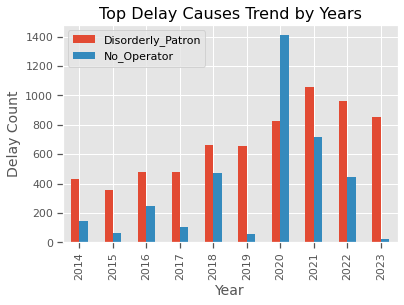

In [29]:
disorderly_patron = real_delay[(real_delay["Code"] == "SUDP") | (real_delay["Code"] == "SRDP")]
disorderly_patron_group = disorderly_patron.groupby(disorderly_patron.index.year)["Min Delay"].count()

no_operator = real_delay[(real_delay['Code'] == "MUNOA") | (real_delay['Code'] == "TUNOA")]
no_operator_group = no_operator.groupby(no_operator.index.year)["Min Delay"].count()

top_delays = pd.DataFrame()
top_delays["Disorderly_Patron"] = disorderly_patron_group
top_delays["No_Operator"] = no_operator_group

plt.figure(figsize = (26,14))
top_delays.plot(kind="bar")
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Delay Count", fontsize = 14)
plt.title("Top Delay Causes Trend by Years", fontsize = 16)

plt.show()

The most common delay reason is disorderly patrons. The cases of disorderly patrons increased by almost 1.5 times since 2020. During the COVID-19 (2020-2022), no operator immediately available became one of the top five reasons. ATC project also became a significant factor in 2018-2022.

In [31]:
# Top 5 Reasons for the recorded delay without causing delays
for i in range(2014, 2024):
    print(i)
    no_delay_reasons = no_delay[no_delay.index.year == i]["Code description"].value_counts(ascending = False)
    print(no_delay_reasons[0:5])
    print()

2014
Operator Overspeeding                                      2855
Miscellaneous Speed Control                                2290
Miscellaneous General Delays                               1412
Passenger Assistance Alarm Activated - No Trouble Found    1073
Miscellaneous Other                                         766
Name: Code description, dtype: int64

2015
Miscellaneous Speed Control                                4034
Operator Overspeeding                                      3169
Miscellaneous General Delays                               1187
Injured or ill Customer (In Station) - Transported         1128
Passenger Assistance Alarm Activated - No Trouble Found    1106
Name: Code description, dtype: int64

2016
Miscellaneous Speed Control                                4267
Operator Overspeeding                                      2512
Injured or ill Customer (In Station) - Transported         1296
Passenger Assistance Alarm Activated - No Trouble Found    1080
Miscellaneous

The good news about the ATC project is less speed control/operator overspeeding cases happen.

In [32]:
# Top 5 Reasons for the recorded delay caused delays by month
for i in range(1, 13):
    print(i)
    real_delay_reasons = real_delay[real_delay.index.month == i]["Code description"].value_counts(ascending = False)
    print(real_delay_reasons[0:5])
    print()

1
Disorderly Patron                                           670
Injured or ill Customer (On Train) - Medical Aid Refused    310
Door Problems - Faulty Equipment                            309
Injured or ill Customer (On Train) - Transported            304
Passenger Assistance Alarm Activated - No Trouble Found     247
Name: Code description, dtype: int64

2
Disorderly Patron                                           627
Injured or ill Customer (On Train) - Medical Aid Refused    290
Injured or ill Customer (On Train) - Transported            244
Door Problems - Faulty Equipment                            229
Passenger Assistance Alarm Activated - No Trouble Found     222
Name: Code description, dtype: int64

3
Disorderly Patron                                           706
Injured or ill Customer (On Train) - Medical Aid Refused    320
Passenger Assistance Alarm Activated - No Trouble Found     274
Door Problems - Faulty Equipment                            233
Injured or ill Custome

In [33]:
# Top 5 Reasons for the recorded delay caused delays by hour
for i in range(0, 24):
    print(i)
    real_delay_reasons = real_delay[real_delay.index.hour == i]["Code description"].value_counts(ascending = False)
    print(real_delay_reasons[0:5])
    print()

0
Disorderly Patron                                           331
Unauthorized at Track Level                                 143
Injured or ill Customer (On Train) - Medical Aid Refused    130
Injured or ill Customer (On Train) - Transported            115
Unsanitary Vehicle                                          110
Name: Code description, dtype: int64

1
Disorderly Patron                                           221
Unauthorized at Track Level                                 108
Injured or ill Customer (On Train) - Transported             82
Passenger Assistance Alarm Activated - No Trouble Found      81
Injured or ill Customer (On Train) - Medical Aid Refused     74
Name: Code description, dtype: int64

2
Disorderly Patron              18
ATC Project                    15
Unauthorized at Track Level    15
Operator Violated Signal       14
Miscellaneous Other             7
Name: Code description, dtype: int64

3
ATC RC&S Equipment                                  3
No Operator Im

4. Time

In [34]:
real_delay.groupby(real_delay.index.year)["Min Delay"].sum()

Datetime
2014    38764
2015    34084
2016    37124
2017    35411
2018    46763
2019    44884
2020    44963
2021    51612
2022    69410
2023    46027
Name: Min Delay, dtype: int64

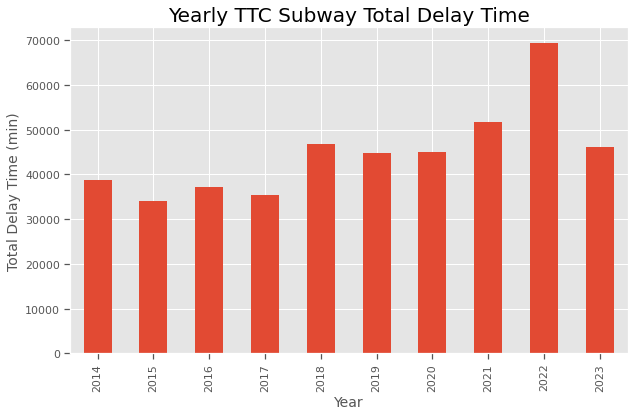

In [35]:
# Total delay counts by year
yearly_delay_time = real_delay.groupby(real_delay.index.year)["Min Delay"].sum()
yearly_delay_time.plot(kind = "bar", figsize = (10, 6))
plt.title("Yearly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)

plt.show()

More delay events during 2022.

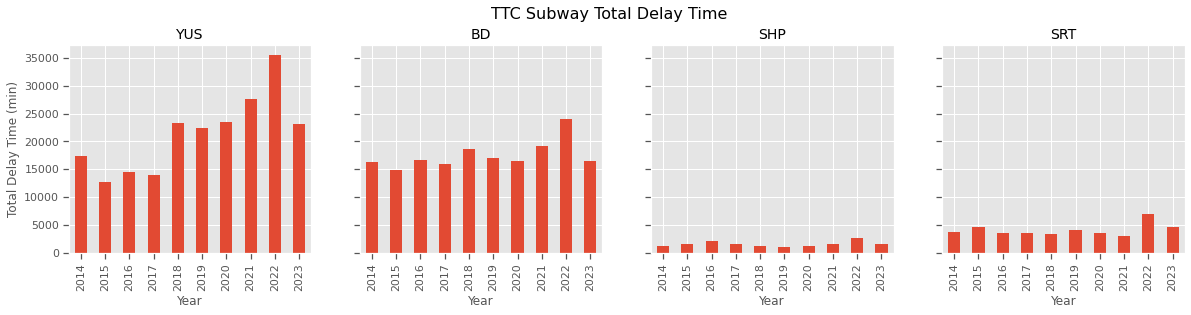

In [36]:
# Total delay counts by year
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Total Delay Time", fontsize = 16)

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    yearly_delay_time_line = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top = 0.85)
plt.show()


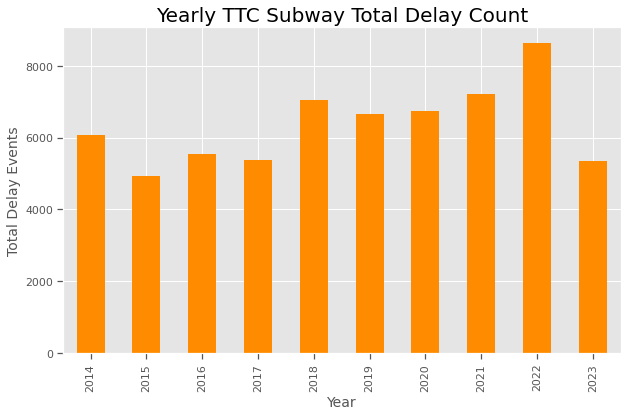

In [37]:
# Total number of delay by year
yearly_delay_count = real_delay.groupby(real_delay.index.year)["Min Delay"].count()
yearly_delay_count.plot(kind = "bar", figsize = (10, 6), color = "darkorange")
plt.title("Yearly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

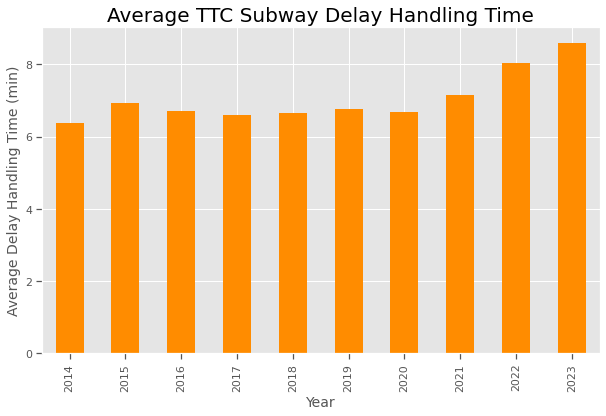

In [38]:
# Total number of delay by year
yearly_delay = yearly_delay_time/yearly_delay_count
yearly_delay.plot(kind = "bar", figsize = (10, 6), color = "darkorange")
plt.title("Average TTC Subway Delay Handling Time", fontsize = 20)
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Average Delay Handling Time (min)", fontsize = 14)

plt.show()

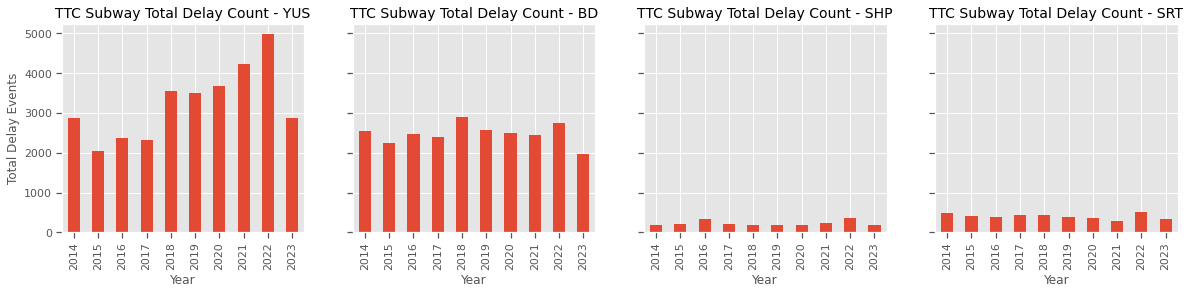

In [39]:
# Total number of delay by year
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]


for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    yearly_delay_count_line = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.85)
plt.show()


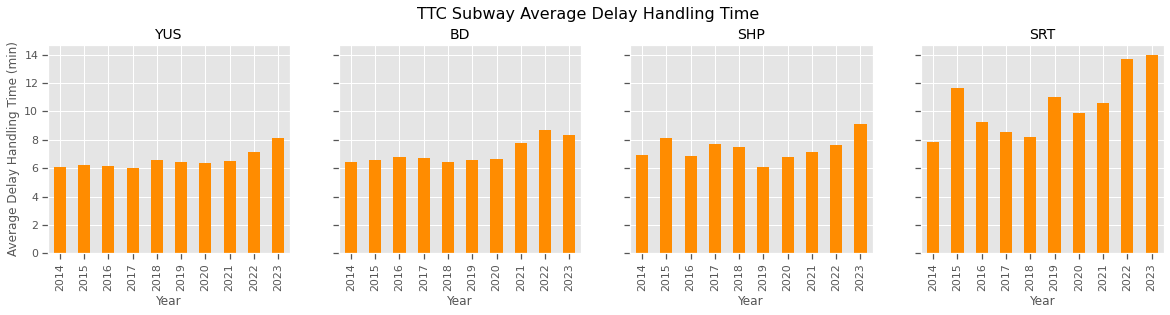

In [40]:
# Total number of delay by year
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Average Delay Handling Time", fontsize = 16)

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    yearly_delay_line = line.groupby(line.index.year)["Min Delay"].sum() / line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_line.plot(ax = axs[i], kind = "bar", color = "darkorange")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Average Delay Handling Time (min)", fontsize = 12)

plt.subplots_adjust(top = 0.85)
plt.show()


Overall, the number of delays events are the same for Bloor-Danford line, Sheppard line and Scarbough Rail Transit. However, Line 1 had significant increasing in delay time and the number of the delay events since 2018. The potential cause is the ATC project.

In [41]:
no_ATC = real_delay[~real_delay["Code"].str.contains("ATC")]
no_ATC["Code"].unique()

array(['MUO', 'MUSAN', 'SUDP', 'MUI', 'TUNOA', 'ERTC', 'EUDO', 'EUBK',
       'ERPR', 'PUSO', 'SUUT', 'TUO', 'MUPR1', 'MUPAA', 'PUSNT', 'MRWEA',
       'MUNOA', 'PUSTS', 'EUTRD', 'PUSSW', 'TUSUP', 'PRSA', 'MUCL',
       'TUNIP', 'PRSO', 'MUIR', 'SUO', 'MRTO', 'MUPLB', 'EUNT', 'TUOS',
       'MRO', 'TRNOA', 'SUSP', 'PUTWZ', 'EUTL', 'PUTIS', 'MUPLA', 'MUDD',
       'MUWR', 'MUD', 'PUSIS', 'ERDB', 'EUBO', 'MUSC', 'PUSRA', 'MUTO',
       'PUTR', 'TUS', 'EUCD', 'PUSCR', 'SUAP', 'ERDO', 'TUMVS', 'MUFM',
       'EUPI', 'PUSI', 'EUO', 'ERLV', 'SRDP', 'TUSC', 'TRTC', 'PUTDN',
       'EUOE', 'EUVE', 'TUCC', 'MUTD', 'EUTR', 'EUME', 'PUTIJ', 'EUYRD',
       'MUIS', 'PRW', 'EUSC', 'SUCOL', 'ERTL', 'PUSTP', 'EUAL', 'PUOPO',
       'MRNOA', 'PUSCA', 'MRDD', 'SUAE', 'PUTSC', 'SUEAS', 'EUCA', 'EUAC',
       'MUFS', 'TUKEY', 'SUBT', 'ERNT', 'SUPOL', 'MUIRS', 'MUWEA',
       'EUNEA', 'ERAC', 'TUDOE', 'MRPLB', 'PUSTC', 'SRO', 'TRNIP', 'PUTO',
       'SUROB', 'EUVA', 'ERO', 'PUCSC', 'MUIE', 'SRAP', 'PUTOE'

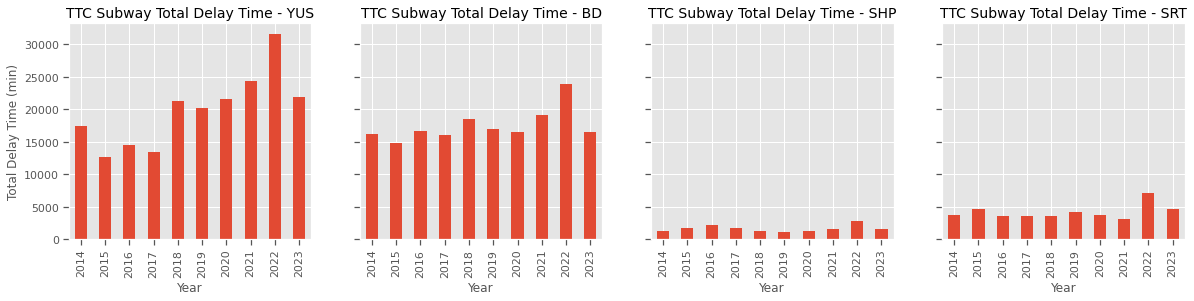

In [42]:
# Total delay counts by year
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = no_ATC[no_ATC["Line"] == subway_lines[i]]    
    yearly_delay_time_line_no_ATC = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_no_ATC.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


How about delay time caused by no operator immediately available?

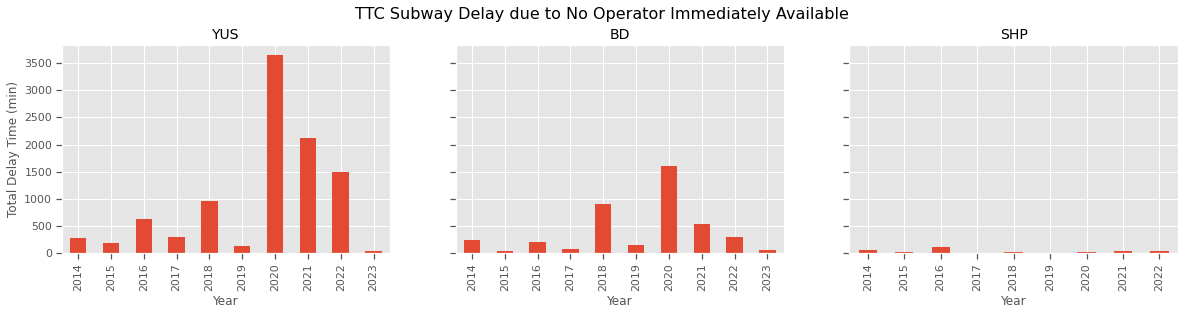

In [43]:
# Total delay minutes due to no operator immediate available
fig, axs = plt.subplots(1, 3, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Delay due to No Operator Immediately Available", fontsize = 16)

for i in range(3):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUESA") | (real_delay["Code"] == "MUNOA") | (real_delay["Code"] == "TUNOA"))]    
    yearly_delay_time_line_no_operator = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_no_operator.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.85)
plt.show()


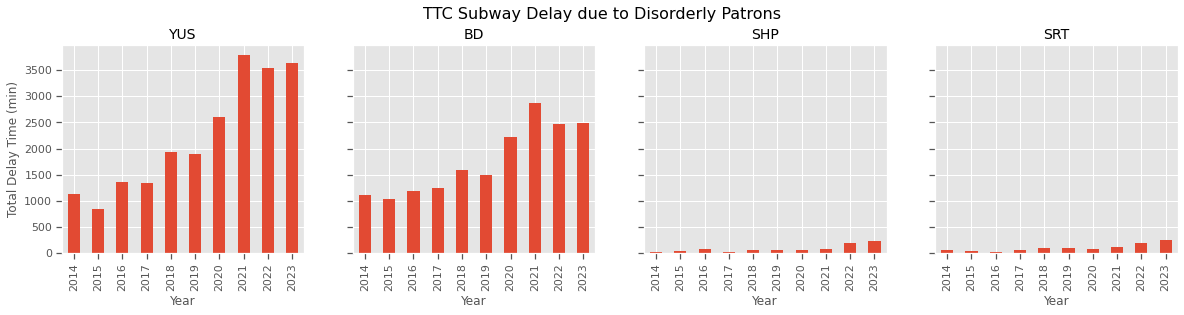

In [44]:
# Total delay minutes due to disorderly patrons
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Delay due to Disorderly Patrons", fontsize = 16)

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "SUDP") | (real_delay["Code"] == "SRDP"))]    
    yearly_delay_time_line_patrons = line.groupby(line.index.year)["Min Delay"].sum()
    yearly_delay_time_line_patrons.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.85)
plt.show()


In [45]:
len(real_delay[real_delay["Code"].isin(["SUDP", "SRDP"])]) / len(real_delay) * 100

10.629190141953353

In [46]:
len(real_delay[real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO"])]) / len(real_delay) * 100

6.606653866733813

In [47]:
len(real_delay[real_delay["Code"].isin(["EUBK"])]) / len(real_delay) * 100

1.3754681942652103

In [48]:
len(real_delay[real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])]) / len(real_delay) * 100


3.418211576595008

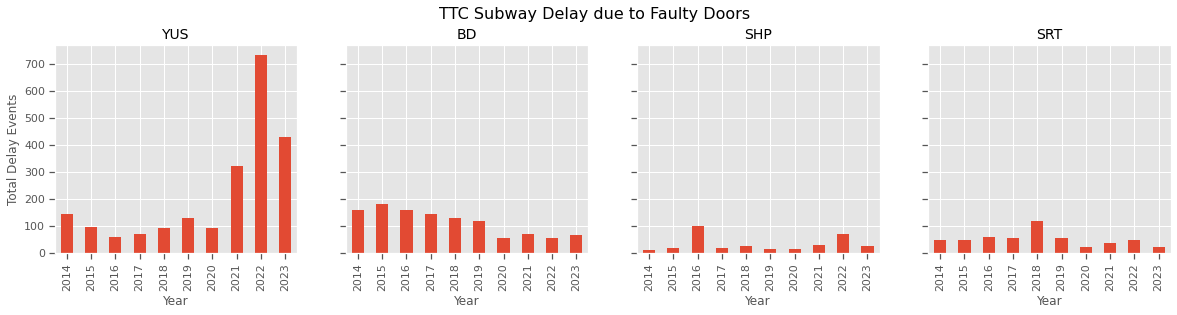

In [49]:
# Total delay minutes due to OPTO (COMMS) Train Door Monitoring or door problem - faulty equipment
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Delay due to Faulty Doors", fontsize = 16)

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO"])]    
    yearly_delay_time_line_faulty_door = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_time_line_faulty_door.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.85)
plt.show()


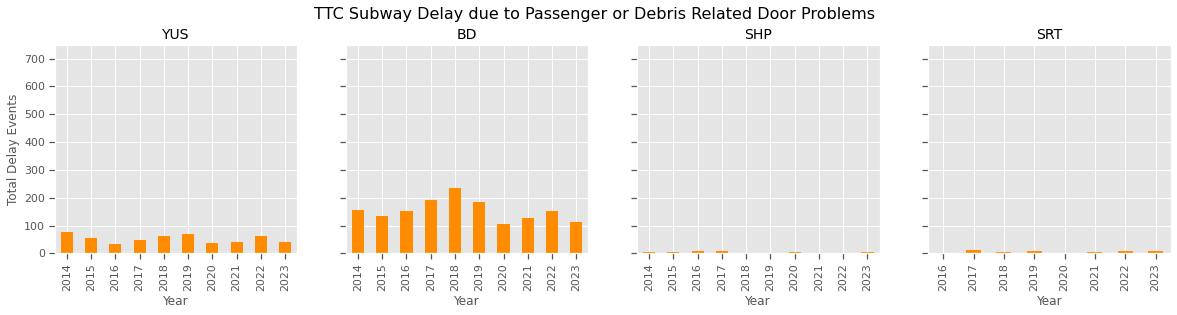

In [50]:
# Total delay minutes due to Door Problems - Passenger Related or Door Problems - Debris Related
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]
fig.suptitle("TTC Subway Delay due to Passenger or Debris Related Door Problems", fontsize = 16)

for i in range(4):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])]    
    yearly_delay_time_line_obstacle_door = line.groupby(line.index.year)["Min Delay"].count()
    yearly_delay_time_line_obstacle_door.plot(ax = axs[i], kind = "bar", color = "darkorange")
    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)
    axs[i].set_ylim(0,750)

plt.subplots_adjust(top=0.85)
plt.show()


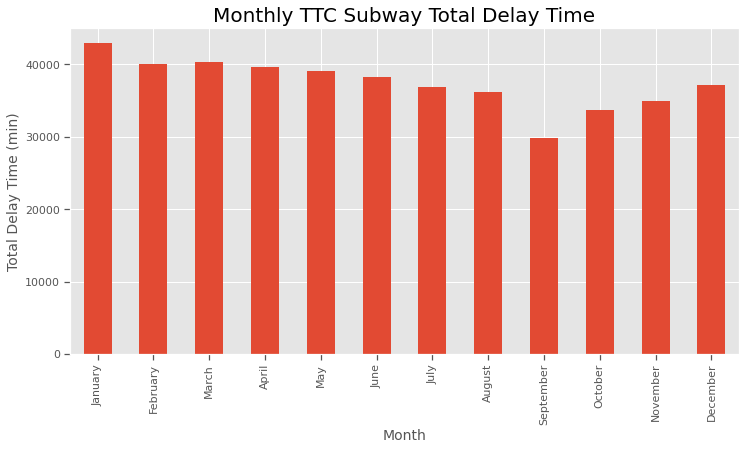

In [51]:
# Total delay time by months
monthly_delay_time = real_delay.groupby(real_delay.index.month)["Min Delay"].sum()
monthly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)
plt.xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.show()

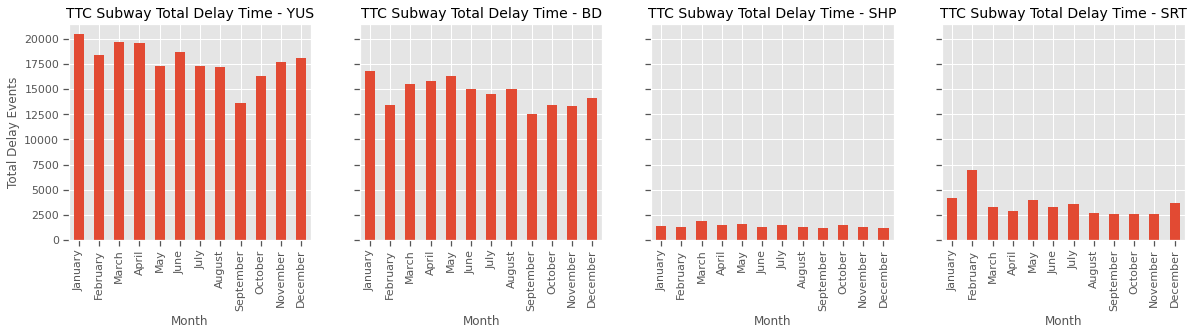

In [52]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    monthly_delay_time_line = line.groupby(line.index.month)["Min Delay"].sum()
    monthly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Month", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)
    axs[i].set_xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.subplots_adjust(top=0.5)
plt.show()


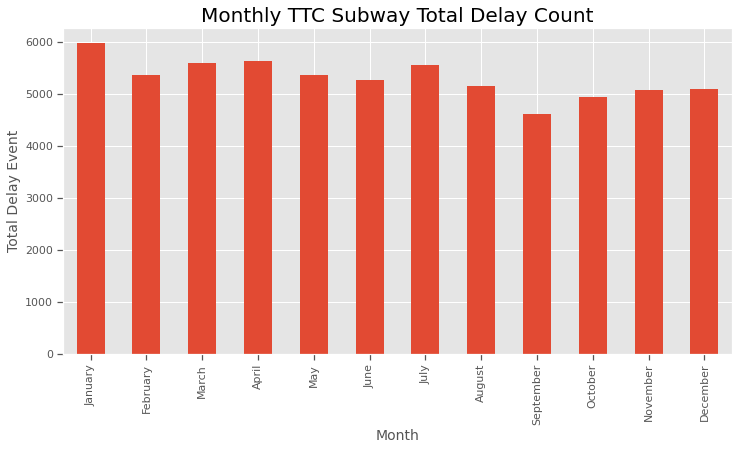

In [53]:
## Total number of delay by months
monthly_delay_count = real_delay.groupby(real_delay.index.month)["Min Delay"].count()
monthly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Monthly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Month", fontsize = 14)
plt.ylabel("Total Delay Event", fontsize = 14)
plt.xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.show()

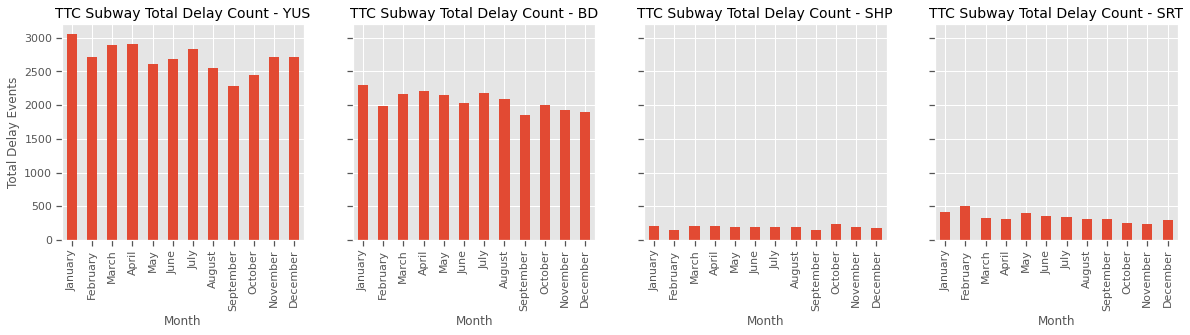

In [54]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    monthly_delay_count_line = line.groupby(line.index.month)["Min Delay"].count()
    monthly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Month", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)
    axs[i].set_xticks(ticks = np.arange(12), labels = ["January","February","March","April","May","June","July", "August", "September", "October", "November", "December"])

plt.subplots_adjust(top=0.5)
plt.show()


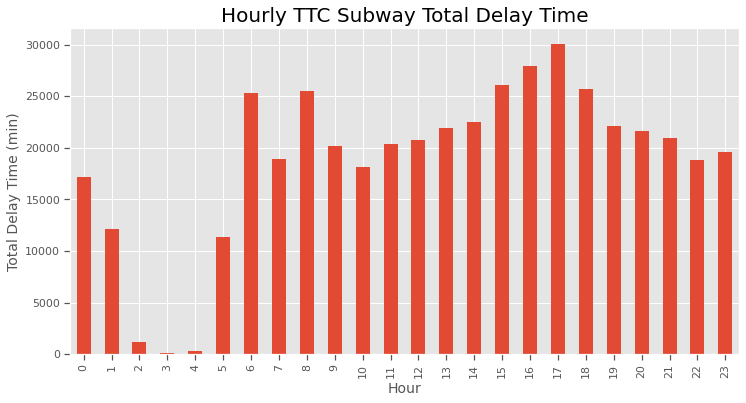

In [55]:
# Total delay time by hours
hourly_delay_time = real_delay.groupby(real_delay.index.hour)["Min Delay"].sum()
hourly_delay_time.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Time", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Time (min)", fontsize = 14)


plt.show()

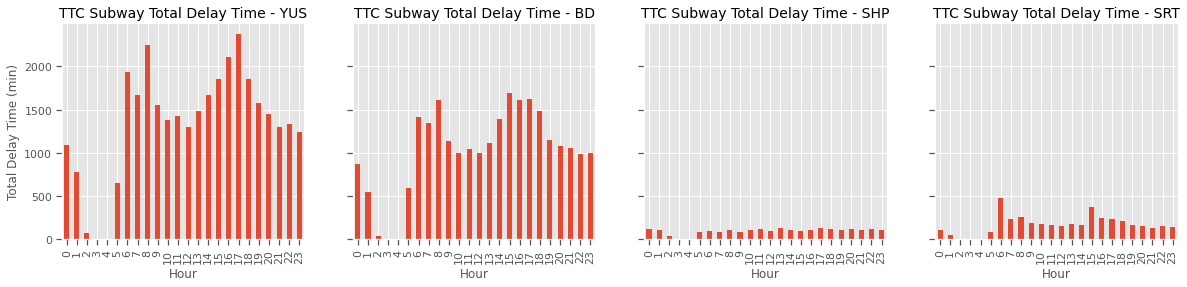

In [56]:
# Total number of delay by hour
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    hourly_delay_time_line = line.groupby(line.index.hour)["Min Delay"].count()
    hourly_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Hour", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


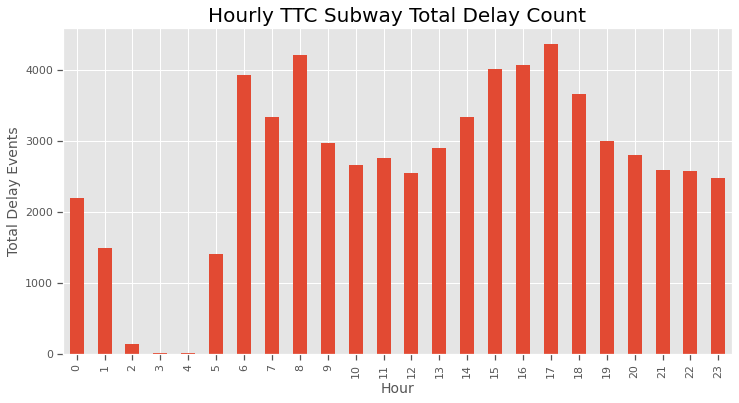

In [57]:
## Total number of delay by hours
hourly_delay_count = real_delay.groupby(real_delay.index.hour)["Min Delay"].count()
hourly_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Hourly TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Hour", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

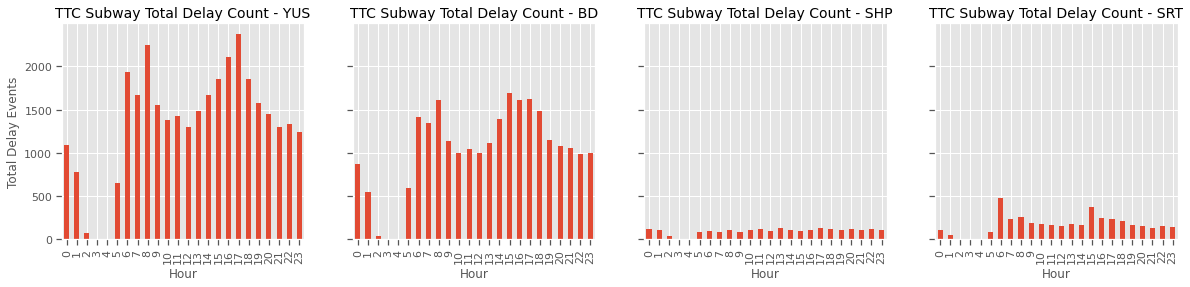

In [58]:
# Total number of delay by month
fig, axs = plt.subplots(1, 4, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    line = real_delay[real_delay["Line"] == subway_lines[i]]    
    hourly_delay_count_line = line.groupby(line.index.hour)["Min Delay"].count()
    hourly_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Count - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Hour", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


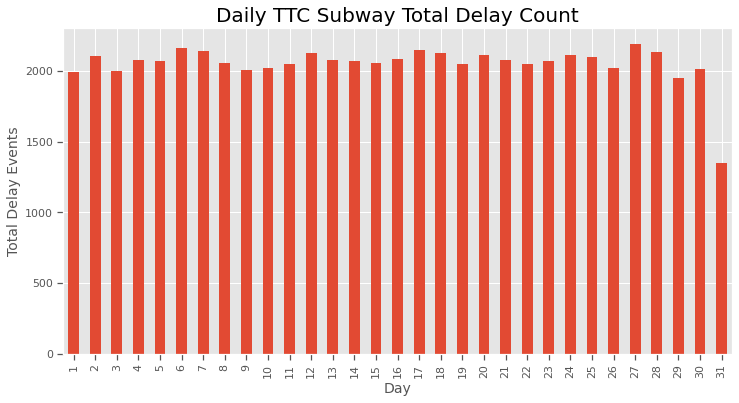

In [59]:
## Total number of delay by hours
daily_delay_count = real_delay.groupby(real_delay.index.day)["Min Delay"].count()
daily_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Daily TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Day", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)

plt.show()

Every day seems have the same amount of delays.

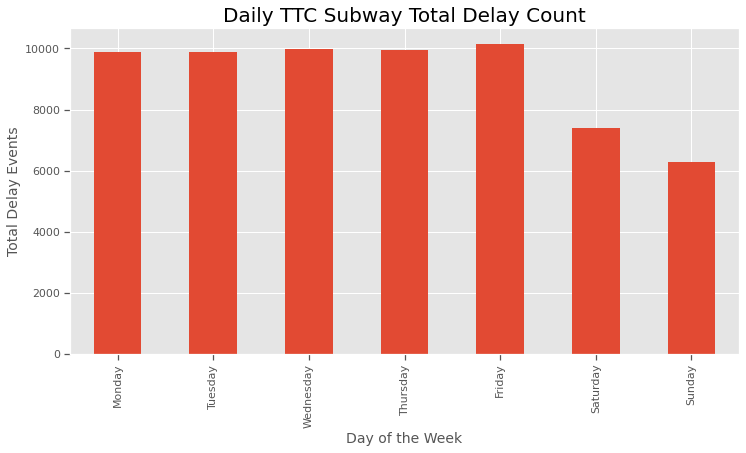

In [60]:
## Total number of delay by hours
weekdays_delay_count = real_delay.groupby(real_delay.index.dayofweek)["Min Delay"].count()
weekdays_delay_count.plot(kind = "bar", figsize = (12, 6))
plt.title("Daily TTC Subway Total Delay Count", fontsize = 20)
plt.xlabel("Day of the Week", fontsize = 14)
plt.ylabel("Total Delay Events", fontsize = 14)
plt.xticks(ticks = np.arange(7), labels = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])

plt.show()

5. Top five reasons for short time and long time delays

In [61]:
# Top delay reasons less than 10 minutes in terms of total delay frequency
short_delay_reason = real_delay[real_delay["Min Delay"] <= 30]["Code description"].value_counts()
short_delay_reason.head(5)

Disorderly Patron                                           6719
Injured or ill Customer (On Train) - Medical Aid Refused    3686
Passenger Assistance Alarm Activated - No Trouble Found     3203
Injured or ill Customer (On Train) - Transported            2893
Door Problems - Faulty Equipment                            2648
Name: Code description, dtype: int64

In [62]:
# Top delay reasons less than 10 minutes in terms of total delay time
short_delay_reason_time = real_delay[real_delay["Min Delay"] <= 30].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
short_delay_reason_time.head(5)

Code description
Disorderly Patron                                           40575
Injured or ill Customer (On Train) - Transported            26233
Injured or ill Customer (On Train) - Medical Aid Refused    20662
Unauthorized at Track Level                                 18980
Passenger Other                                             15139
Name: Min Delay, dtype: int64

In [63]:
# Top delay reasons for less than 10 minutes
top_short_delay_reasons = list(set(list(short_delay_reason[0:5].index) + list(short_delay_reason_time[0:5].index)))
top_short_delay_reasons

['Injured or ill Customer (On Train) - Transported',
 'Passenger Assistance Alarm Activated - No Trouble Found',
 'Unauthorized at Track Level',
 'Injured or ill Customer (On Train) - Medical Aid Refused',
 'Door Problems - Faulty Equipment',
 'Disorderly Patron',
 'Passenger Other']

In [64]:
# Filter out short delays
top_short_delay_time = real_delay[real_delay["Code description"].isin(top_short_delay_reasons)]
top_short_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 02:42:00,Monday,COLLEGE STATION,SUDP,7,12,N,YUS,5696,Disorderly Patron,02:00 - 03:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 08:41:00,Monday,VICTORIA PARK STATION,EUDO,6,10,W,BD,5030,Door Problems - Faulty Equipment,08:00 - 09:00
2018-01-01 11:46:00,Monday,KENNEDY BD STATION,SUUT,4,8,W,BD,5046,Unauthorized at Track Level,11:00 - 12:00
2018-01-01 15:36:00,Monday,SHERBOURNE STATION,SUDP,5,10,E,BD,5269,Disorderly Patron,15:00 - 16:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 21:33:00,Sunday,QUEEN STATION,SUUT,5,9,N,YUS,5736,Unauthorized at Track Level,21:00 - 22:00
2017-12-31 21:52:00,Sunday,YORK MILLS STATION,SUDP,3,8,N,YUS,5851,Disorderly Patron,21:00 - 22:00
2017-12-31 22:46:00,Sunday,BROADVIEW STATION,SUDP,4,8,E,BD,5261,Disorderly Patron,22:00 - 23:00


['Injured or ill Customer (On Train)\n - Transported', 'Passenger Assistance Alarm Activated\n - No Trouble Found', 'Unauthorized at Track Level', 'Injured or ill Customer (On Train)\n - Medical Aid Refused', 'Door Problems\n - Faulty Equipment', 'Disorderly Patron', 'Passenger Other']


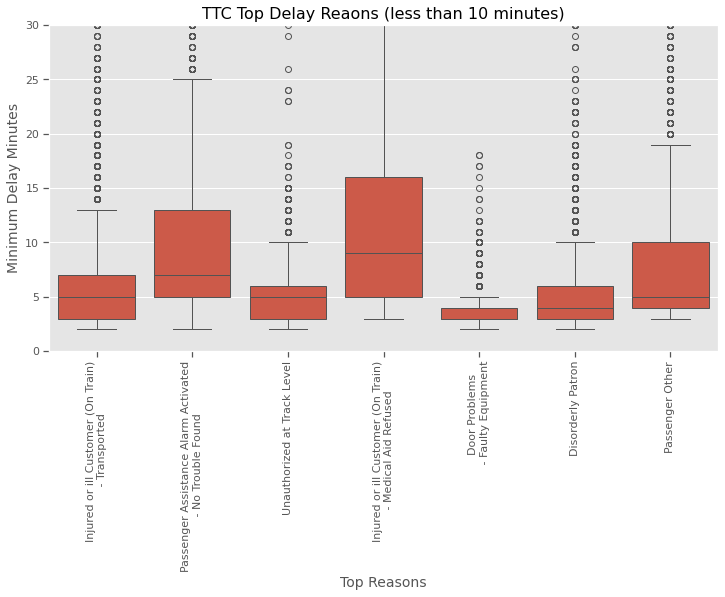

In [65]:
plt.figure(figsize = (12, 6))
formatted_legend = ['\n - '.join(s.split(' - ')) if ' - ' in s else s for s in top_short_delay_reasons]
print(formatted_legend)
sns.boxplot(x=top_short_delay_time["Code description"], y=top_short_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (less than 10 minutes)", fontsize = 16)
plt.xlabel("Top Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(range(len(formatted_legend)), formatted_legend, rotation = 90)
plt.ylim(0,30)
plt.show()

In [66]:
# Top delay reasons more than 10 minutes
long_delay_reason = real_delay[real_delay["Min Delay"] > 30]["Code description"].value_counts()
long_delay_reason.head(5)

Priority One - Train in Contact With Person         259
Fire/Smoke Plan B - Source TTC                      149
Unauthorized at Track Level                         121
Track Switch Failure - Signal Related Problem        39
Injured or ill Customer (On Train) - Transported     39
Name: Code description, dtype: int64

In [67]:
long_delay_reason_time = real_delay[real_delay["Min Delay"] > 30].groupby("Code description")["Min Delay"].sum().sort_values(ascending = False)
long_delay_reason_time.head(5)

Code description
Priority One - Train in Contact With Person      23896
Fire/Smoke Plan B - Source TTC                    8732
Unauthorized at Track Level                       5991
Track Switch Failure - Signal Related Problem     2189
Miscellaneous Other                               2187
Name: Min Delay, dtype: int64

In [68]:
top_long_delay_reasons = list(set(list(long_delay_reason[0:5].index) + list(long_delay_reason_time[0:5].index)))
top_long_delay_reasons

['Injured or ill Customer (On Train) - Transported',
 'Unauthorized at Track Level',
 'Priority One - Train in Contact With Person',
 'Fire/Smoke Plan B - Source TTC',
 'Miscellaneous Other',
 'Track Switch Failure - Signal Related Problem']

In [69]:
top_long_delay_time = real_delay[real_delay["Code description"].isin(top_long_delay_reasons)]
top_long_delay_time

,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code description,time_interval
Datetime,,,,,,,,,,
2018-01-01 01:39:00,Monday,MUSEUM STATION,MUO,6,11,S,YUS,5781,Miscellaneous Other,01:00 - 02:00
2018-01-01 03:06:00,Monday,WARDEN STATION,MUI,3,7,E,BD,5257,Injured or ill Customer (On Train) - Transported,03:00 - 04:00
2018-01-01 11:46:00,Monday,KENNEDY BD STATION,SUUT,4,8,W,BD,5046,Unauthorized at Track Level,11:00 - 12:00
2018-01-01 16:47:00,Monday,VICTORIA PARK STATION,MUPR1,62,67,W,BD,5225,Priority One - Train in Contact With Person,16:00 - 17:00
2018-01-01 16:50:00,Monday,VICTORIA PARK STATION,MUO,39,44,E,BD,5010,Miscellaneous Other,16:00 - 17:00
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 13:35:00,Sunday,ISLINGTON STATION,MUPR1,91,96,E,BD,5050,Priority One - Train in Contact With Person,13:00 - 14:00
2017-12-31 14:08:00,Sunday,WOODBINE STATION,MUPLB,15,20,W,BD,5246,Fire/Smoke Plan B - Source TTC,14:00 - 15:00
2017-12-31 17:58:00,Sunday,JANE STATION,MUPR1,103,107,W,BD,5346,Priority One - Train in Contact With Person,17:00 - 18:00


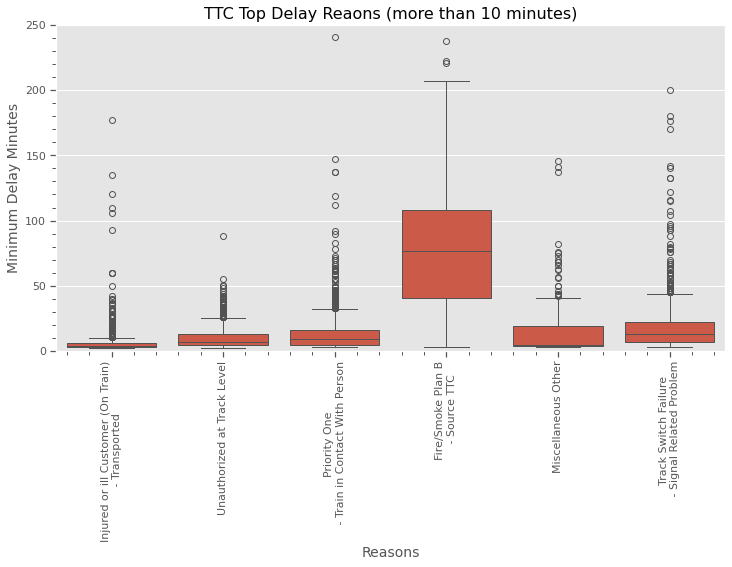

In [70]:
plt.figure(figsize = (12, 6))
formatted_legend = ['\n - '.join(s.split(' - ')) if ' - ' in s else s for s in top_long_delay_reasons]
sns.boxplot(x=top_long_delay_time["Code description"], y=top_long_delay_time["Min Delay"])
plt.title("TTC Top Delay Reaons (more than 10 minutes)", fontsize = 16)
plt.xlabel("Reasons", fontsize = 14)
plt.ylabel("Minimum Delay Minutes", fontsize = 14)
plt.xticks(range(len(formatted_legend)), formatted_legend, rotation = 90)
plt.ylim(0, 250)
plt.minorticks_on()
plt.show()

6. Mechanical Issues

Codes start with "E" or "P" are mechanical or signal issues from TTC.

In [71]:
TTC_delay_code_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Code              200 non-null    object
 1   Code description  200 non-null    object
dtypes: object(2)
memory usage: 4.2+ KB


In [72]:
mech_code = [TTC_delay_code_name["Code"][i] for i in range(len(TTC_delay_code_name["Code"])) if isinstance(TTC_delay_code_name["Code"][i], str) and (TTC_delay_code_name["Code"][i].startswith("E") or TTC_delay_code_name["Code"][i].startswith("P"))]
print(mech_code)

['EUAC', 'EUAL', 'EUATC', 'EUBK', 'EUBO', 'EUCA', 'EUCD', 'EUCH', 'EUCO', 'EUDO', 'EUECD', 'EUHV', 'EULT', 'EULV', 'EUME', 'EUNEA', 'EUNT', 'EUO', 'EUOE', 'EUOPO', 'EUPI', 'EUSC', 'EUTL', 'EUTM', 'EUTR', 'EUTRD', 'EUVA', 'EUVE', 'EUYRD', 'PUATC', 'PUCBI', 'PUCSC', 'PUCSS', 'PUDCS', 'PUMEL', 'PUMO', 'PUMST', 'PUOPO', 'PUSAC', 'PUSBE', 'PUSCA', 'PUSCR', 'PUSEA', 'PUSI', 'PUSIO', 'PUSIS', 'PUSLC', 'PUSNT', 'PUSO', 'PUSRA', 'PUSSW', 'PUSTC', 'PUSTP', 'PUSTS', 'PUSWZ', 'PUSZC', 'PUTCD', 'PUTD', 'PUTDN ', 'PUTIJ', 'PUTIS', 'PUTNT', 'PUTO', 'PUTOE', 'PUTR', 'PUTS', 'PUTSC', 'PUTSM', 'PUTTC', 'PUTTP', 'PUTWZ', 'ERAC', 'ERBO', 'ERCD', 'ERCO', 'ERDB', 'ERDO', 'ERHV', 'ERLT', 'ERLV', 'ERME', 'ERNEA', 'ERNT', 'ERO', 'ERPR', 'ERRA', 'ERTB', 'ERTC', 'ERTL', 'ERTR', 'ERVE', 'ERWA', 'ERWS', 'PREL', 'PRO', 'PRS', 'PRSA', 'PRSL', 'PRSO', 'PRSP', 'PRST', 'PRSW', 'PRTST', 'PRW']


In [73]:
# Most common mechanical issues
mech_issues = real_delay[real_delay["Code"].isin(mech_code)].groupby("Code")["Min Delay"].count().sort_values(ascending = False)
mech_issues.head(10)

Code
EUDO     2128
PUOPO    1549
EUNT      994
EUBK      874
PUSTS     571
ERDO      521
ERTC      503
EUBO      492
EUPI      385
PUSTC     352
Name: Min Delay, dtype: int64

As the table above, door issues (EUDO, PUOPO, ERDO) are the most common mechanical issues. Followed by break issues.

In [74]:
# Total number of mechanical issues over ten years
mech_issues.values.sum()

15394

In [75]:
print("There are {}% of delay caused by mechanical issues.".format(round(mech_issues.values.sum() / len(real_delay.index)*100, 2)))

There are 24.23% of delay caused by mechanical issues.


In [76]:
# Number of door issues
door_issues = real_delay[real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO", "MUD", "MUDD", "MRD", "MRDD"])]
print("There are {}% of mechanical issues were related to doors.".format(round(door_issues["Vehicle"].count()/mech_issues.values.sum() * 100, 2)))

There are 41.38% of mechanical issues were related to doors.


In [77]:
# Number of brake issues
brake_issues = real_delay[real_delay["Code"]=="EUBK"]
print("There are {}% of mechanical issues were related to brakes.".format(round(brake_issues["Vehicle"].count()/mech_issues.values.sum() * 100, 2)))

There are 5.68% of mechanical issues were related to brakes.


In [78]:
print("There were {} trains experienced delay.".format(real_delay["Vehicle"].nunique()))

There were 900 trains experienced delay.


In [79]:
# Creat a new Dataframe
train = pd.DataFrame()
# Count how many delay from each train
train["Count"] = real_delay[(real_delay["Code"].isin(mech_code)) & (real_delay["Vehicle"] != 0)].groupby(["Vehicle"])["Code"].count().sort_values(ascending = False)
train.head()

,Count
Vehicle,
3007,133
3017,103
3025,94
3013,90
3000,88


In [80]:
# Find the subway lines for each vehicle
train["Line"] = [real_delay[real_delay["Vehicle"] == num]["Line"].unique() for num in train.index]
# Convert the list to string
train['Line'] = train['Line'].apply(lambda x: ', '.join(sorted(x)))
train.head()

,Count,Line
Vehicle,,
3007,133,"BD, SRT"
3017,103,SRT
3025,94,SRT
3013,90,SRT
3000,88,SRT


In [81]:
# Find the subway lines for each vehicle
train["Year"] = [real_delay[real_delay["Vehicle"] == num].index.year.unique().astype(str) for num in train.index]
# Convert the list to string
train['Year'] = train['Year'].apply(lambda x: ', '.join(sorted(x)))
train.head()

,Count,Line,Year
Vehicle,,,
3007,133,"BD, SRT","2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3017,103,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3025,94,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3013,90,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."
3000,88,SRT,"2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021..."


<Figure size 864x576 with 0 Axes>

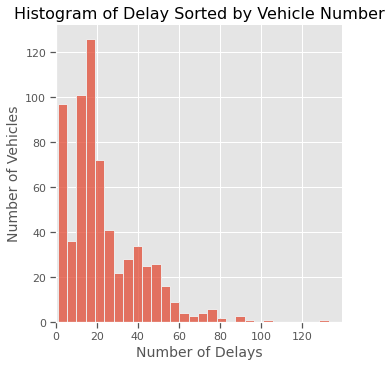

In [82]:
plt.figure(figsize = (12, 8))
# Plot the histogram of the delay event related to number of vehicles
sns.displot(train["Count"])
plt.title("Histogram of Delay Sorted by Vehicle Number", fontsize = 16)
plt.xlabel("Number of Delays", fontsize = 14)
plt.ylabel("Number of Vehicles", fontsize = 14)
plt.xlim(0)

plt.show()

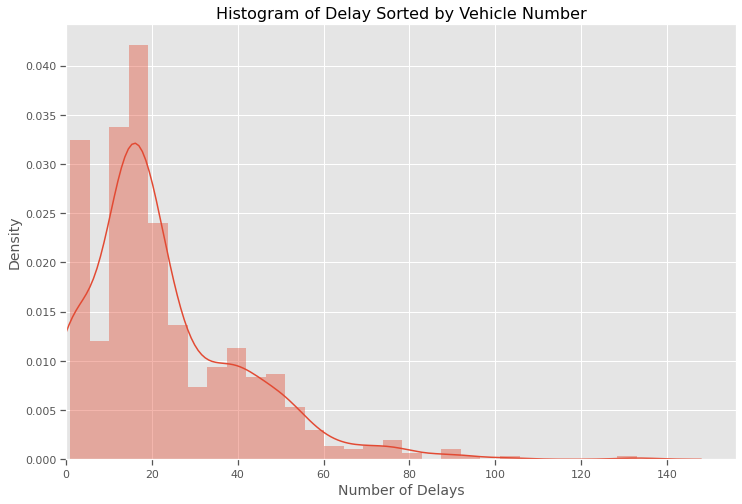

In [83]:
# Set the figure size
plt.figure(figsize = (12, 8))
# Plot the histogram of the delay event related to number of vehicles
sns.distplot(train["Count"])

# Add plot title, labels and set the limit
plt.title("Histogram of Delay Sorted by Vehicle Number", fontsize = 16)
plt.xlabel("Number of Delays", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.xlim(0)

plt.show()

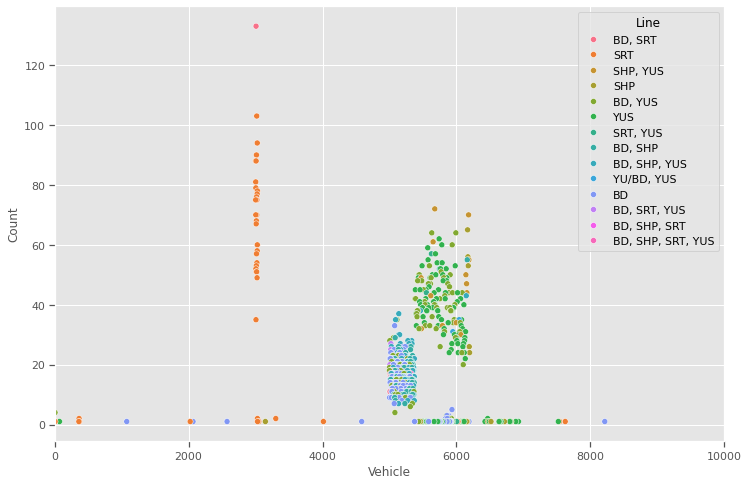

In [84]:
# See the vehicle number correlation
plt.figure(figsize = (12, 8))
sns.scatterplot(x = train.index, y = train["Count"], hue = train["Line"])
plt.xlim(0,10000)

plt.show()

7. Top Delay Reason for each station

In [85]:
real_delay["Station"].unique()

array(['SHEPPARD WEST STATION', 'MUSEUM STATION', 'KIPLING STATION',
       'COLLEGE STATION', 'WARDEN STATION', 'DONLANDS STATION',
       'KEELE STATION', 'KENNEDY SRT STATION', 'VICTORIA PARK STATION',
       'OLD MILL STATION', 'DAVISVILLE STATION', 'KENNEDY BD STATION',
       'ST GEORGE BD STATION', 'SHERBOURNE STATION', 'EGLINTON STATION',
       'PAPE STATION', 'BLOOR STATION', 'ST PATRICK STATION',
       'MCCOWAN STATION', 'YORK MILLS STATION', 'FINCH STATION',
       'GREENWOOD STATION', 'KING STATION', 'WILSON STATION',
       'VAUGHAN MC STATION', 'WILSON YARD', 'GREENWOOD YARD',
       'UNION STATION', 'FINCH WEST STATION', 'COXWELL STATION',
       'YORKDALE STATION', 'ST CLAIR STATION', 'JANE STATION',
       'LAWRENCE STATION', 'MIDLAND STATION', 'BAY STATION',
       'EGLINTON WEST STATION', 'DUPONT STATION', 'WELLESLEY STATION',
       "QUEEN'S PARK STATION", 'ISLINGTON STATION', 'SPADINA YUS STATION',
       'DUFFERIN STATION', 'ELLESMERE STATION', 'ST CLAIR WEST ST

In [86]:
## The count here shows number 
TTC_delay_stations_count = real_delay.groupby(["Station"]).agg(total_count=('Code', 'count'), max_delay_code=('Code', 'max')).sort_values(by='total_count', ascending=False)
TTC_delay_stations_count.head()

,total_count,max_delay_code
Station,,
FINCH STATION,2762,TUSUP
KENNEDY BD STATION,2742,TUSUP
VAUGHAN MC STATION,2387,TUSUP
EGLINTON STATION,2320,TUSUP
KIPLING STATION,2281,TUSUP


In [87]:
TTC_delay_stations_count["max_delay_code"].unique()

array(['TUSUP', 'TUSC', 'TRTC', 'TUSET', 'TUS', 'TUTD', 'TUOS', 'TUST',
       'TRSET', 'TUATC', 'PUTSM', 'SRO', 'TUNOA', 'TUO', 'SUUT', 'TUMVS',
       'TRO', 'PRSO', 'SUDP', 'TUNIP', 'PUSRA', 'PUSTS', 'SUEAS', 'TUCC',
       'MUTO', 'PUSNT', 'MRTO', 'ERTC', 'PUTIJ', 'PUTWZ', 'MUATC', 'PUTR',
       'PUCSS', 'MUIS', 'PUSI', 'PUCSC', 'PUSSW', 'PUSWZ', 'MUTD', 'MUSC',
       'MUNOA', 'ERDO', 'MUPLB', 'EUBK', 'PUSCA', 'PUSZC', 'SUPOL',
       'PUEO', 'SUO', 'EUVE', 'MUFM', 'MUO', 'EUTRD', 'PRS', 'MUPAA',
       'PRO', 'PRSA', 'MUDD', 'PUTO', 'PUSTC', 'PUSO', 'PRSL', 'PUSIO',
       'EUSC', 'EUPI', 'PUMO', 'SUAP', 'EUDO', 'EUTM', 'PUTS', 'MUSAN',
       'EUATC', 'ERHV', 'PUEWZ', 'PUSIS', 'EUNT', 'PUOPO', 'PUATC',
       'MUPR1', 'ERPR', 'SREAS', 'MUI', 'MRWEA', 'PUSAC', 'PRW', 'EUBO',
       'SUG'], dtype=object)

In [88]:
TTC_delay_stations_count[~TTC_delay_stations_count["max_delay_code"].isin(["TUSUP", "TUSC"])].head(10)

,total_count,max_delay_code
Station,,
MCCOWAN STATION,1551,TRTC
WARDEN STATION,1280,TUSET
KENNEDY SRT STATION,957,TRTC
ST CLAIR STATION,888,TUS
ISLINGTON STATION,787,TUTD
COLLEGE STATION,691,TUOS
WELLESLEY STATION,684,TUS
OSSINGTON STATION,668,TUST
SPADINA BD STATION,637,TUS


We are suspect that the door problem usually happen at the exchange stations between two lines since people may run to catch the subway. The relevent codes are: ["MUD", "MUDD", "MRD", "MRDD"]

In [89]:
real_delay[real_delay["Code"].isin(["MUD", "MUDD", "MRD", "MRDD"])].groupby("Station")["Min Delay"].count().sort_values(ascending = False).head(10)

Station
YONGE BD STATION         168
ST GEORGE BD STATION     109
KENNEDY BD STATION        83
SHERBOURNE STATION        65
ISLINGTON STATION         65
WARDEN STATION            61
SPADINA BD STATION        61
KIPLING STATION           56
VICTORIA PARK STATION     55
DUFFERIN STATION          53
Name: Min Delay, dtype: int64

In [90]:
real_delay[real_delay["Code"].isin(["PUOPO", "EUDO", "ERDO"])].groupby("Station")["Min Delay"].count().sort_values(ascending = False).head(10)

Station
HIGHWAY 407 STATION      198
SPADINA YUS STATION      131
YORKDALE STATION         124
LAWRENCE EAST STATION    105
ST GEORGE YUS STATION    104
LESLIE STATION           104
WILSON STATION           100
KENNEDY SRT STATION       99
KENNEDY BD STATION        98
MCCOWAN STATION           90
Name: Min Delay, dtype: int64

Yonge BD station and St. George BD station are two main interchange station with the most significant door issues due to passengers and debris. The potential reason is the subway schedule for two lines are too close. Passengers tried to exchange the subway at the last minute.

8. Weather Issue

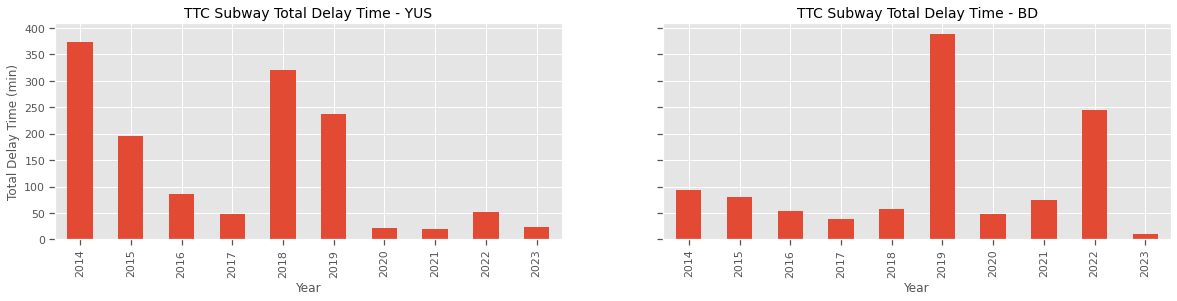

In [91]:
# Total delay minutes due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_time_line = line.groupby(line.index.year)["Min Delay"].sum()
    weather_delay_time_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


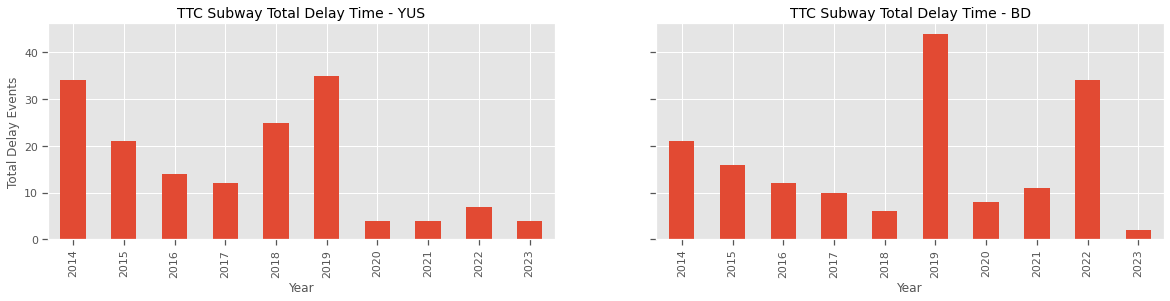

In [92]:
# Total delay events due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_count_line = line.groupby(line.index.year)["Min Delay"].count()
    weather_delay_count_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


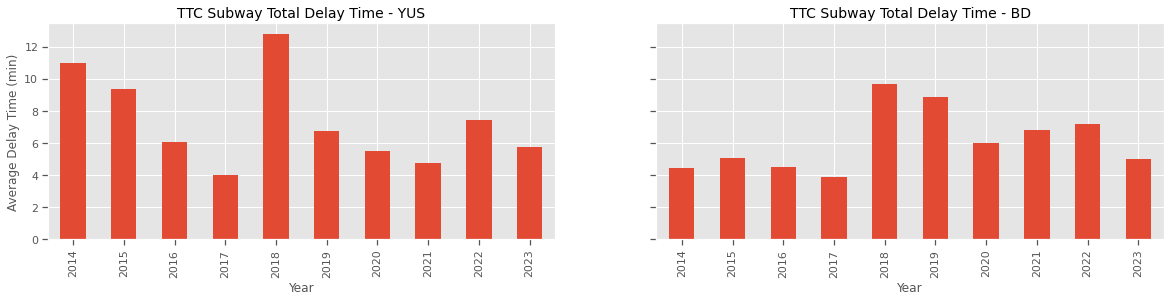

In [93]:
# Total delay events due to weather
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey= True)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(2):
    line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "MUWEA") | (real_delay["Code"] == "PUSIS") | (real_delay["Code"] == "MRWEA"))]    
    weather_delay_line = line.groupby(line.index.year)["Min Delay"].sum()/line.groupby(line.index.year)["Min Delay"].count()
    weather_delay_line.plot(ax = axs[i], kind = "bar")
    axs[i].set_title(f"TTC Subway Total Delay Time - {subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Average Delay Time (min)", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


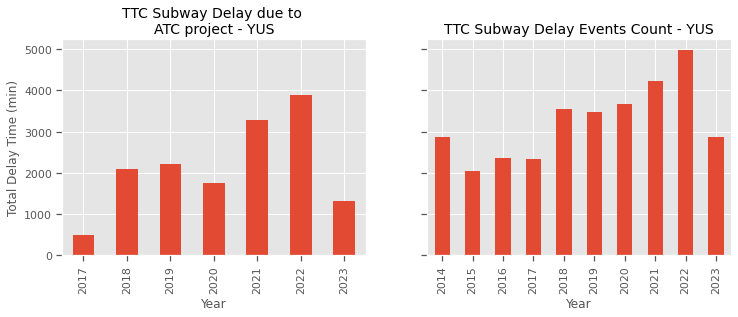

In [94]:
# Total delay counts by year
fig, axs = plt.subplots(1, 2, figsize = (12, 8), sharey= True)

ATC = real_delay[real_delay["Code"].str.contains("ATC")]
line = ATC[ATC["Line"] == "YUS"]    
ATC_delay = line.groupby(line.index.year)["Min Delay"].sum()
ATC_delay.plot(ax = axs[0], kind = "bar")
axs[0].set_title(f"TTC Subway Delay due to \nATC project - YUS", fontsize = 14)
axs[0].set_xlabel("Year", fontsize = 12)
axs[0].set_ylabel("Total Delay Time (min)", fontsize = 12)

line = real_delay[real_delay["Line"] == "YUS"]    
yearly_delay_count_YUS = line.groupby(line.index.year)["Min Delay"].count()
yearly_delay_count_YUS.plot(ax = axs[1], kind = "bar")
axs[1].set_title(f"TTC Subway Delay Events Count - YUS", fontsize = 14)
axs[1].set_xlabel("Year", fontsize = 12)
axs[1].set_ylabel("Total Delay Events", fontsize = 12)

plt.subplots_adjust(top=0.5)
plt.show()


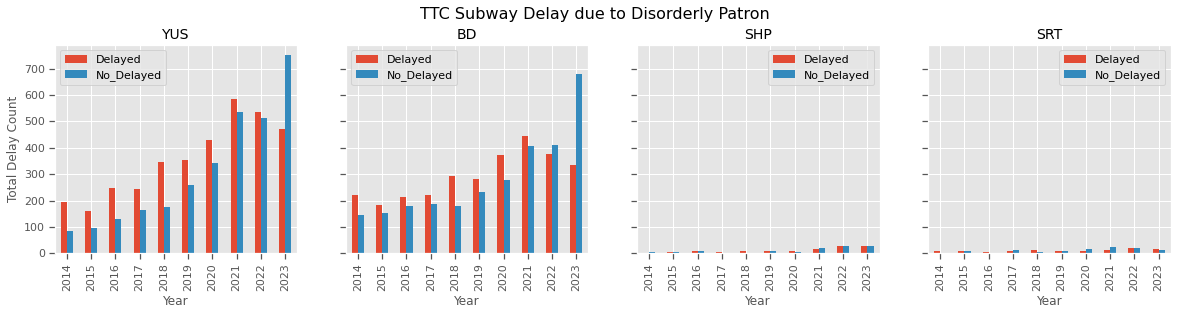

In [95]:
# Total number of delay by hour
fig, axs = plt.subplots(1, 4, figsize = (20, 4), sharey= True)
fig.suptitle("TTC Subway Delay due to Disorderly Patron", fontsize = 16)
subway_lines = ["YUS", "BD", "SHP", "SRT"]

for i in range(4):
    dp_delay = pd.DataFrame()
    delay_line = real_delay[(real_delay["Line"] == subway_lines[i]) & ((real_delay["Code"] == "SUDP") | (real_delay["Code"] == "SRDP"))]    
    yearly_delay_time_line_dp = delay_line.groupby(delay_line.index.year)["Min Delay"].count()


    no_delay_line = no_delay[(no_delay["Line"] == subway_lines[i]) & ((no_delay["Code"] == "SUDP") | (no_delay["Code"] == "SRDP"))]    
    yearly_no_delay_time_line_dp = no_delay_line.groupby(no_delay_line.index.year)["Min Delay"].count()
    
    dp_delay["Delayed"] = yearly_delay_time_line_dp
    dp_delay["No_Delayed"] = yearly_no_delay_time_line_dp

    dp_delay.plot(ax = axs[i], kind = "bar")


    axs[i].set_title(f"{subway_lines[i]}", fontsize = 14)
    axs[i].set_xlabel("Year", fontsize = 12)
    axs[i].set_ylabel("Total Delay Count", fontsize = 12)

plt.subplots_adjust(top=0.85)
plt.show()
